In [1]:
cur_date = "082922"

library(readxl)
library(tidyverse)
library(reshape2)
suppressPackageStartupMessages(library(dendextend))
library(pheatmap)

# reading in files
mediator_df = data.frame(read_excel("Input/Allostatic_Mediator_Data_061722ap.xlsx", sheet = 2))
allostatic_scores_df = data.frame(read_excel("Input/082922_Allostatic_Load_Scores.xlsx"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




Using hierarchical clustering to create a heatmap to determine how cytokines cluster and seeing how those clusters differ by adding in various covariates.

In [2]:
# combining into 1 df 
mediator_df = inner_join(mediator_df, allostatic_scores_df %>%
               # removing allostatic scores that were calculated based on stratified covariates
                            filter(Covariate == "NA")) %>%
    filter(Category == "Cytokine") %>%
    # removing covariate and category columns
                            select(-c("Covariate", "Category")) %>%
    # scaling within each cytokine
    group_by(Variable) %>%
    mutate(Norm_Value = scale(Value)) %>%
    ungroup() %>%
    # making allostatic load scores binary based on if the allostatic load was < or > 1
    mutate(Allostatic_Load_Categorical = ifelse(Allostatic_Load < 1, "Low", "High"))

head(mediator_df)

Joining, by = c("Group", "Subject_ID")


Study,Original_Subject_Number,Subject_Number,Group,Subject_ID,Sex,Age,Race,Variable,Value,Allostatic_Load,Norm_Value,Allostatic_Load_Categorical
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,"<dbl[,1]>",<chr>
FM2,97,1,CS,CS_1,M,18,B,IP10,0.0990,1.054743,-0.5346488,High
FM2,99,2,CS,CS_2,F,20,W,IP10,0.3560,0.830954,-0.5342898,Low
FM2,101,3,CS,CS_3,F,20,W,IP10,0.2140,0.521715,-0.5344882,Low
FM2,98,4,CS,CS_4,F,21,W,IP10,0.0840,1.867653,-0.5346697,High
TCORS LAIV,39,5,CS,CS_5,M,21,W,IP10,123.0310,1.941798,-0.3629642,High
FM2,100,6,CS,CS_6,F,22,W,IP10,0.1075,0.336339,-0.5346369,Low


In [3]:
# determing average cytokine concentrations for each subject to order the dataframe for the heat map
avg_subject_id_df = mediator_df %>%
    group_by(Group, Subject_ID) %>%
    # added 1 to each value so I wouldn't have to deal with negatives
    summarize(Avg_Norm_Value = mean(Norm_Value + 1))%>%
    arrange(-Avg_Norm_Value) %>%
    ungroup() %>%
    group_by(Group) %>%
    group_split()

head(avg_subject_id_df[[1]])

ordered_subject_ids = c(avg_subject_id_df[[2]]$Subject_ID, avg_subject_id_df[[1]]$Subject_ID)
head(ordered_subject_ids)

`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


Group,Subject_ID,Avg_Norm_Value
<chr>,<chr>,<dbl>
CS,CS_2,2.133890
CS,CS_4,1.908170
CS,CS_14,1.873101
CS,CS_18,1.865773
CS,CS_12,1.800228
CS,CS_19,1.741810


[1] "NS_48" "NS_61" "NS_52" "NS_43" "NS_36" "NS_62"

In [4]:
# ADD WORDS
clustering_df_1 = mediator_df[,c(5,9,12)] %>%
    pivot_wider(names_from = Subject_ID, values_from = Norm_Value) %>%
    column_to_rownames(var = "Variable")

# ordering subject ids for heat map
clustering_df_1 = clustering_df_1[,ordered_subject_ids]

head(clustering_df_1)

,NS_48,NS_61,NS_52,NS_43,NS_36,NS_62,NS_45,NS_44,NS_35,NS_42,⋯,CS_17,CS_28,CS_33,CS_24,CS_32,CS_5,CS_27,CS_10,CS_26,CS_8
,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",⋯,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
IP10,-0.5345880,0.7907390,-0.3533949,-0.5346083,-0.5346460,5.5336142,-0.5346655,-0.53465784,-0.5344086,1.60274625,⋯,0.2165863,0.1075691,0.9417108,0.2572198,-0.3598736,-0.3629642,-0.3772568,-0.4733500,-0.08799973,-0.1428379
IFNg,0.8442389,-0.5371394,2.6355501,0.2361428,1.1936368,0.2559186,0.5018842,-0.04923731,1.4222389,-0.06346919,⋯,-0.7129528,-0.7147961,-1.0669139,-0.7092670,-0.7850612,-0.9574550,-0.9290667,-0.9802691,-0.93473373,-0.9669490
IL10,0.2065270,4.7332875,1.0165537,-0.9924061,1.4167282,0.1295748,0.4896642,-0.06823196,1.0571244,-0.20760507,⋯,-0.4693586,-0.5023075,-0.6704416,-0.3870090,-0.5253750,-0.5912985,-0.7496291,-0.5484454,-0.59789219,-0.6374603
IL12p70,2.8839026,-0.2932781,2.0806761,0.7697572,1.0466283,-0.9358531,-0.1650926,0.22707932,0.3037577,0.64776410,⋯,-0.5790905,-0.8143900,-0.6108723,-0.6527940,-0.3383315,-0.3045749,-0.6003099,-0.7948040,-0.84337680,-0.9533711
IL13,1.6789213,-0.5265457,2.4241549,0.9046270,0.4415228,-0.6936208,0.4680846,0.53483661,1.0234300,0.19959645,⋯,-0.6327024,-0.6464440,-0.5624896,-0.8001360,-0.4383355,-0.5337753,-0.5553424,-0.6869753,-0.63958678,-0.5978937
IL1B,-0.1040153,-0.1375117,-0.1082063,-0.1170762,-0.1260478,-0.1375117,-0.1133412,-0.13238637,-0.1240294,-0.11944627,⋯,-0.1375117,-0.1375117,-0.1375117,-0.1375117,-0.1375117,-0.1375117,-0.1375117,-0.1375117,-0.13751170,-0.1375117


# Hierarchical Clustering Heat Map

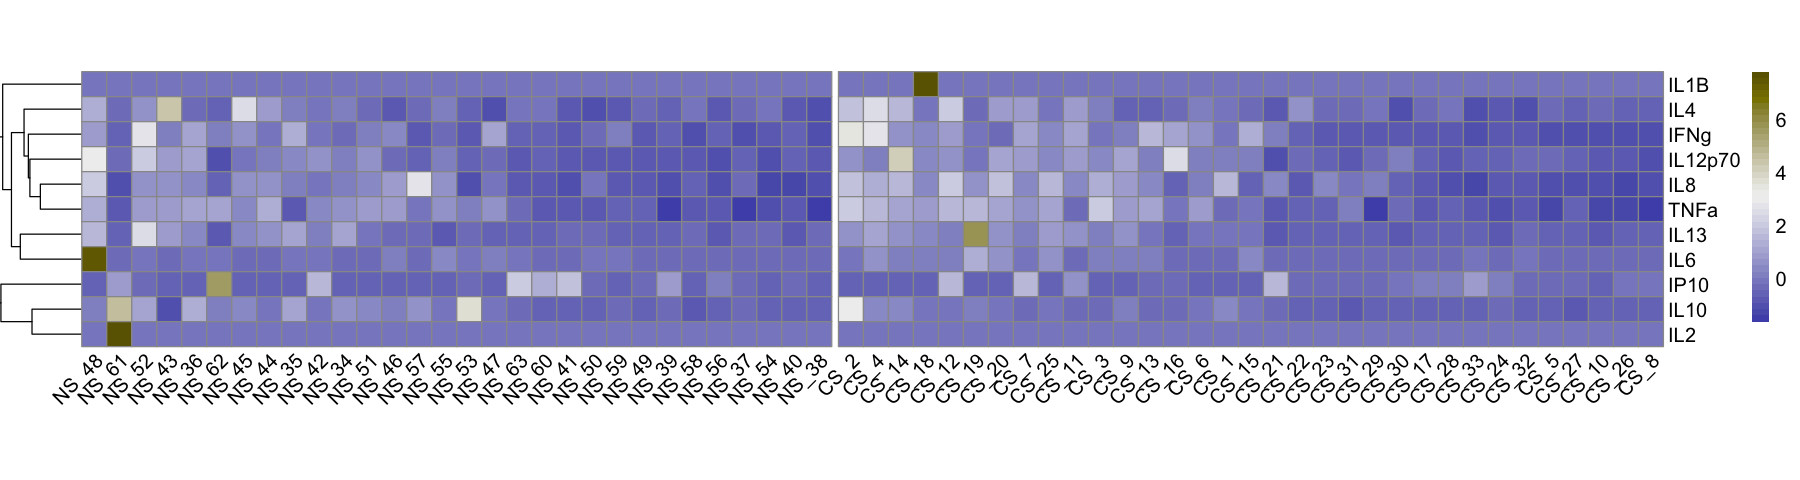

In [5]:
options(repr.plot.width=15, repr.plot.height=4) #changing size
pheatmap(clustering_df_1, cluster_rows = TRUE, cluster_cols = FALSE, legend = TRUE,
         angle_col = 45, fontsize = 12,  
         cellheight = 15, cellwidth = 15,
         color = hcl.colors(40, "Blue-Yellow 2"),
         gaps_col = 30) # adds a break bewtween exposure groups

# Heat Map Clustered by Sex

In [6]:
# creating a sex df for the annotation col
sex_df = mediator_df %>%
    select(c("Subject_ID", "Sex")) %>%
    unique() %>%
    column_to_rownames(var = "Subject_ID")

head(sex_df)

,Sex
,<chr>
CS_1,M
CS_2,F
CS_3,F
CS_4,F
CS_5,M
CS_6,F


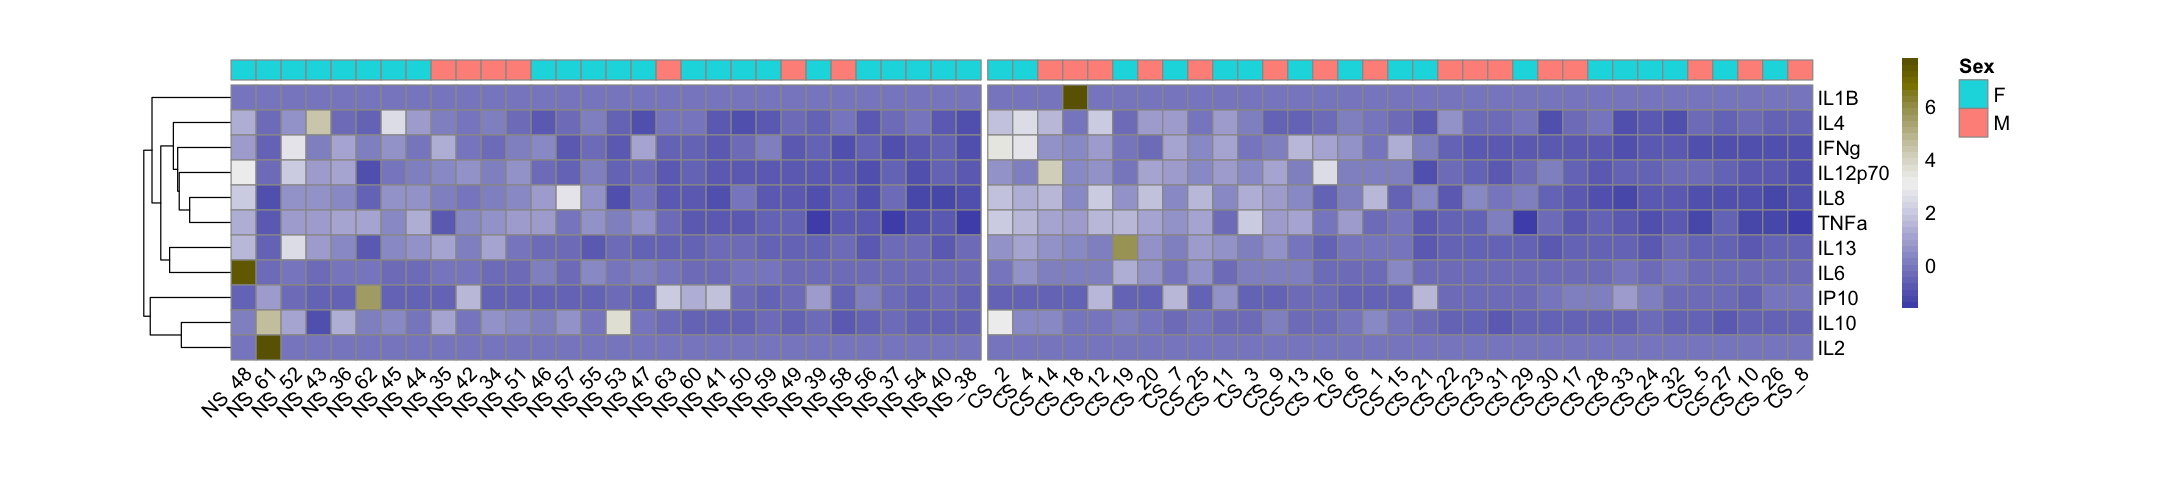

In [7]:
options(repr.plot.width=18, repr.plot.height=4) #changing size
pheatmap(clustering_df_1, cluster_rows = TRUE, cluster_cols = FALSE, legend = TRUE,
         angle_col = 45, fontsize = 12,  
         cellheight = 15, cellwidth = 15,
         color = hcl.colors(40, "Blue-Yellow 2"),
         gaps_col = 30, # adds a break bewtween exposure groups
         annotation_col = sex_df, annotation_names_col = FALSE)

# Heat Map Clustered by Allostatic Load

In [12]:
# creating a sex df for the annotation col
binary_allostatic_load_df = mediator_df %>%
    select(c("Subject_ID", "Allostatic_Load_Categorical")) %>%
    unique() %>%
    column_to_rownames(var = "Subject_ID")

colnames(binary_allostatic_load_df) = c("Allostatic Load")

head(binary_allostatic_load_df)

,Allostatic Load
,<chr>
CS_1,High
CS_2,Low
CS_3,Low
CS_4,High
CS_5,High
CS_6,Low


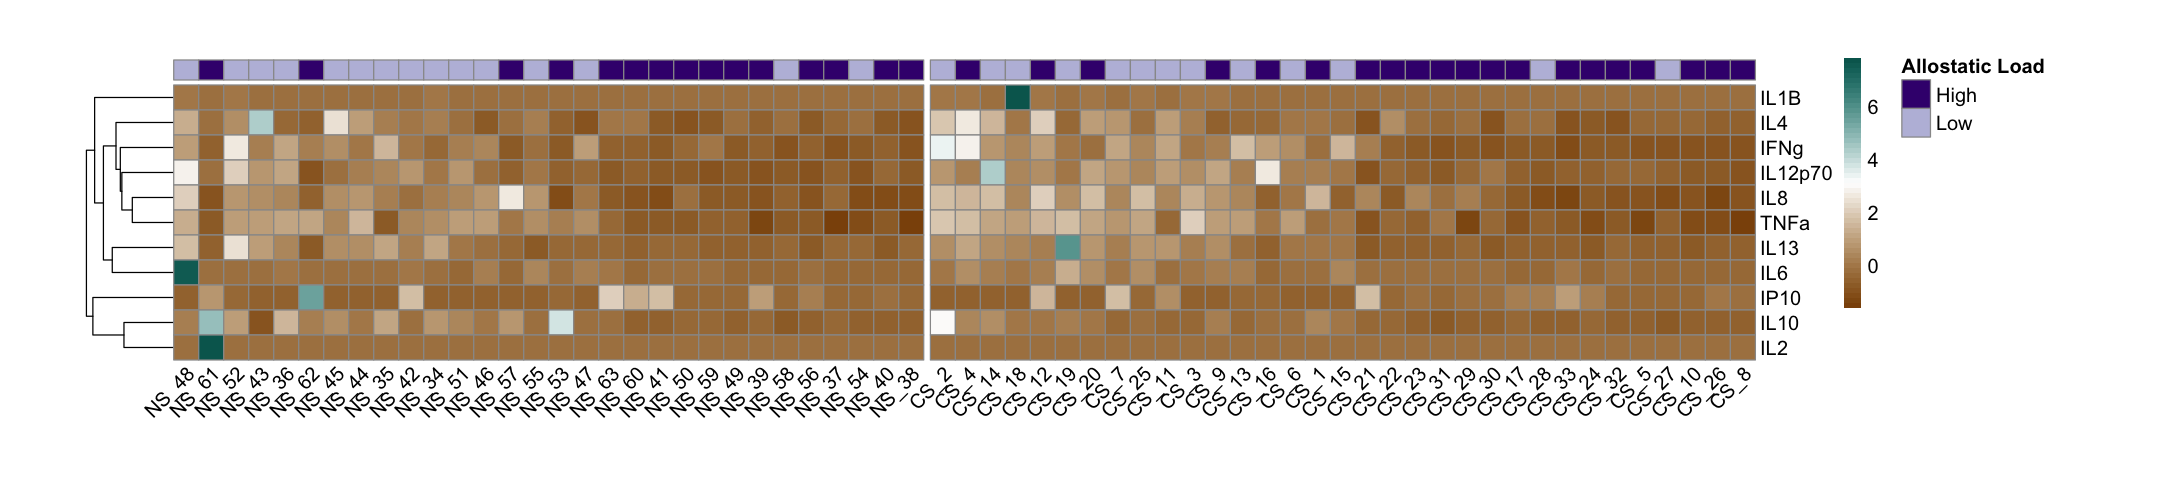

In [28]:
options(repr.plot.width=18, repr.plot.height=4) #changing size
pheatmap(clustering_df_1, cluster_rows = TRUE, cluster_cols = FALSE, legend = TRUE,
         angle_col = 45, fontsize = 12,  
         cellheight = 15, cellwidth = 15,
         color = colorRampPalette(c("#8c510a", "white", "#01665e"))(50),
         gaps_col = 30, # adds a break bewtween exposure groups
         annotation_col = binary_allostatic_load_df, annotation_names_col = FALSE,
         annotation_colors = list(`Allostatic Load` = c(High = "#3f007d", Low = "#bcbddc")))

In [29]:
install.packages("gplots")
library(gplots)

also installing the dependencies ‘gtools’, ‘caTools’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




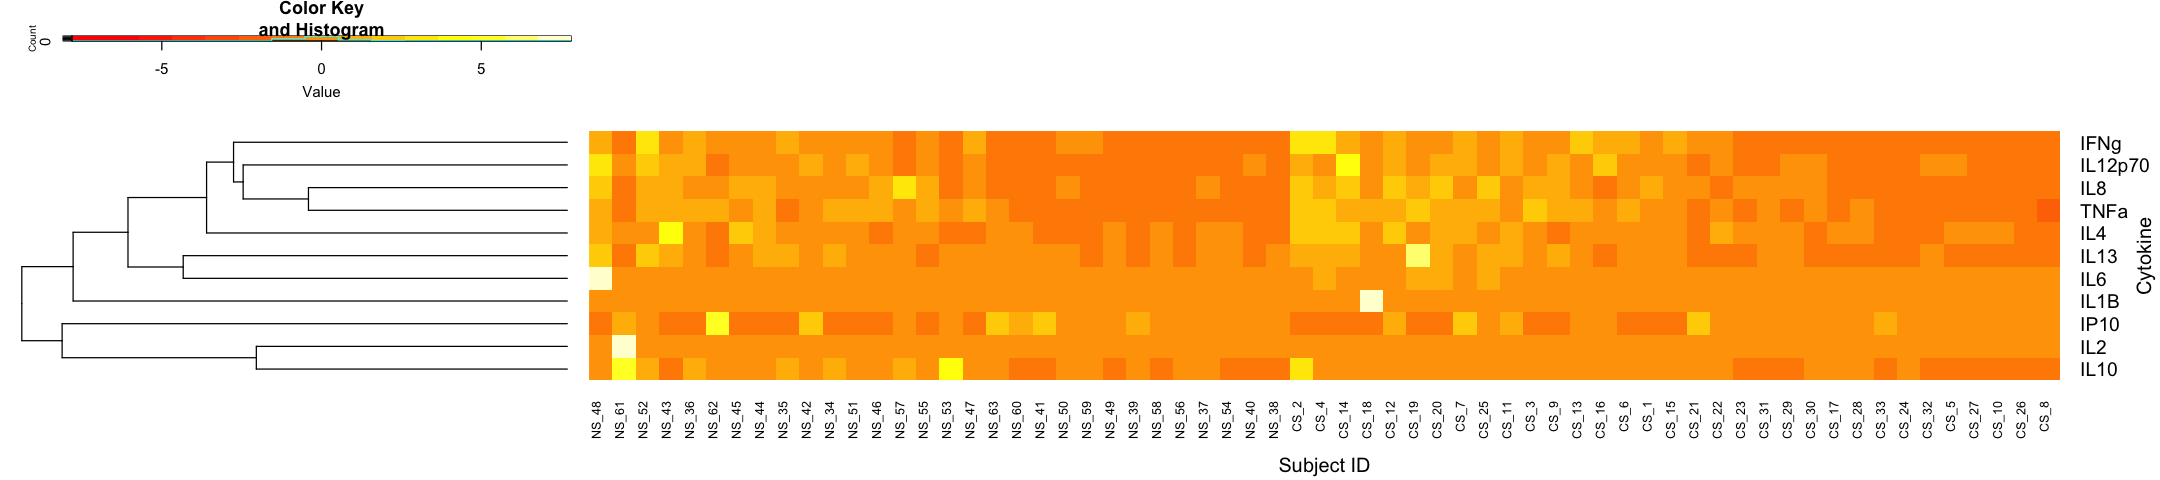

In [38]:
heatmap.2(x = as.matrix(clustering_df_1), dendrogram = "row",  ylab = "Cytokine",
    xlab = "Subject ID", Colv=FALSE, trace="none" )